# Reflect Tables into SQLAlchemy ORM

In [132]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.sql import func
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import pandas as pd
from pandas import DataFrame
from flask import Flask, jsonify

In [133]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [134]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [135]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [136]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [137]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [138]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [139]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [140]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [141]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [142]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [143]:
#Get the Dates for the past 12 months
base_date = datetime.datetime.strptime("2017-7-21", "%Y-%m-%d")
numdays = 365
date_list = [base_date - datetime.timedelta(days=x) for x in range(0, numdays)]

# Converting them to a list of strings
str_dates = []
for date in date_list:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)

In [144]:
# Getting precipitation data
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
               .filter(Measurement.date.in_(str_dates))\
               .group_by(Measurement.date)

In [145]:
#Convert that to a List
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])

In [146]:
#put that into a DataFrame and sort by date
prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-07-22,0.0185714
2016-07-23,0.177143
2016-07-24,0.0683333
2016-07-25,0.361429
2016-07-26,0.151667


<IPython.core.display.Javascript object>


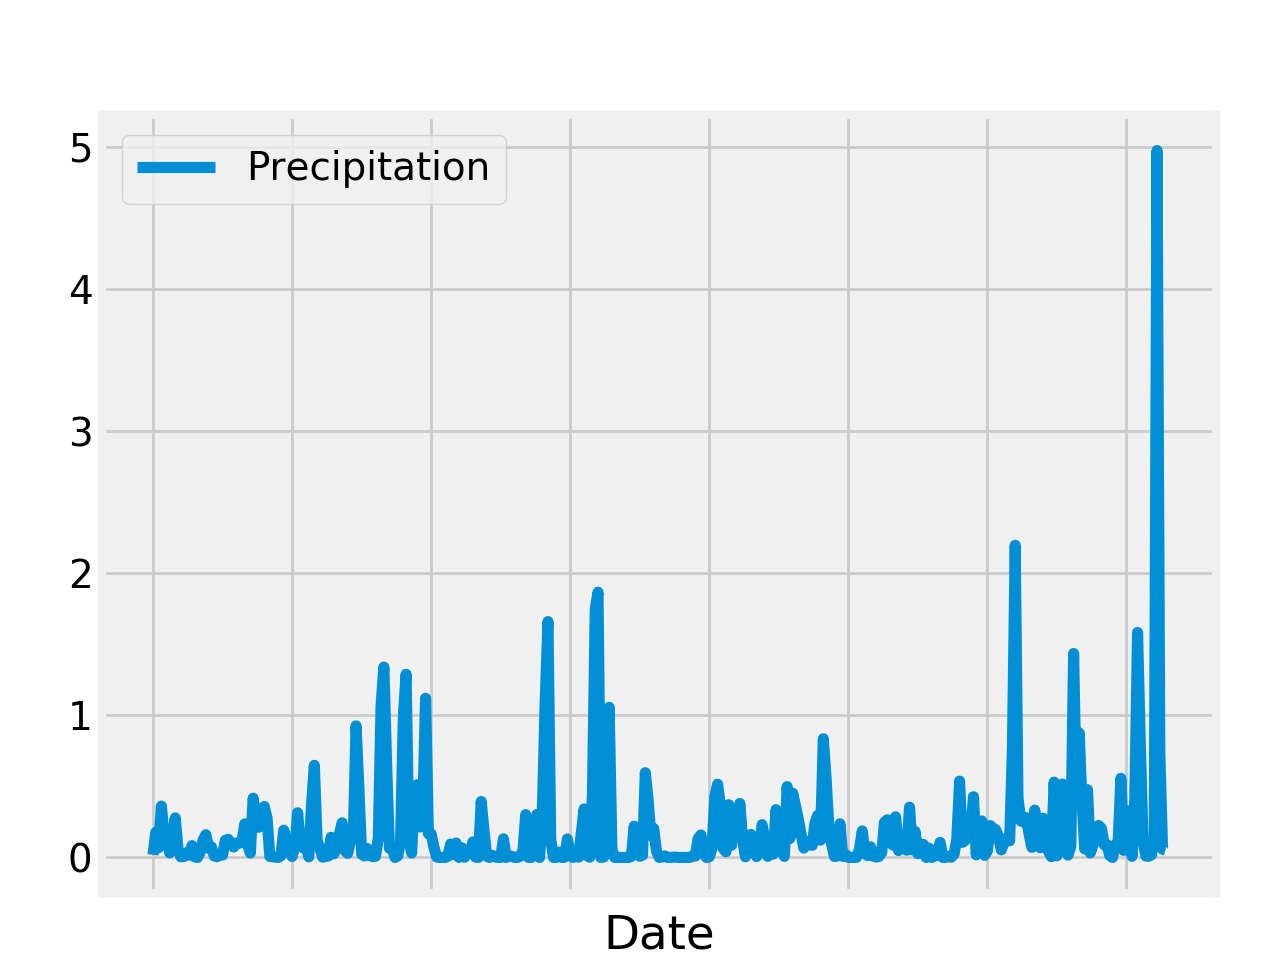

In [147]:
# Plot the prcp data
prcp_df.plot()
plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [148]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df["Precipitation"].describe()

count     365.0
unique    268.0
top         0.0
freq       45.0
Name: Precipitation, dtype: float64

# Station Analysis

In [149]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(18)

In [150]:
#Find the Observation
ob_counts = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())

In [151]:
#Print
for station in ob_counts:
    print(station)

# Store
top_station = ob_counts[0][0]

('USC00519281', 5544)
('USC00519397', 5409)
('USC00513117', 5405)
('USC00519523', 5241)
('USC00516128', 5096)
('USC00514830', 4139)
('USC00511918', 3911)
('USC00517948', 2055)
('USC00518838', 853)


In [152]:
#Get the last 12 months of data 
tobs_result = session.query(Measurement.tobs)\
               .filter(Measurement.date.in_(str_dates))\
               .filter(Measurement.station == top_station)
#Make a list to make life easy
tobs_data = []
for row in tobs_result:
    tobs_data.append(row[0])

<IPython.core.display.Javascript object>


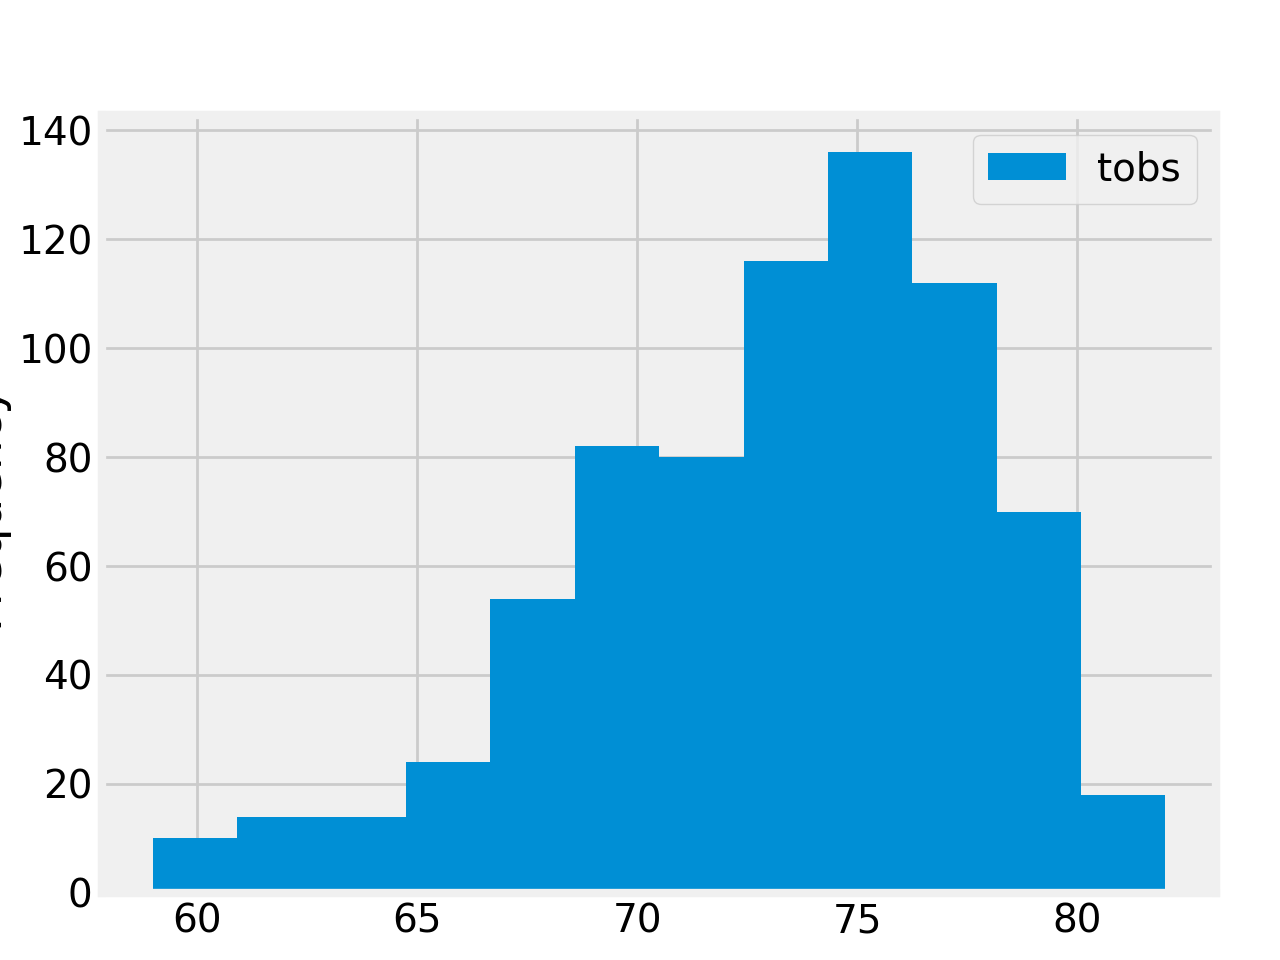

In [153]:
#Plot histogram
plt.hist(tobs_data, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/station_analysis.png")
plt.show()